# ATLAS Integrated Experiments on Colab GPU

This notebook runs the complete ATLAS pipeline:
- **Phase 1**: Gradient-based task clustering
- **Phase 2**: Heterogeneous LoRA rank allocation
- **Phase 3**: Split federated learning
- **Phase 4**: MIRA Laplacian regularization

**Modes:**
- `quick`: 2 tasks, 4 clients, 500 samples, 5 rounds (~15-20 min)
- `full`: 3 tasks, 9 clients, 2000 samples, 10 rounds (~2-3 hours)

**Device Simulation:**
- CPU 2GB
- Tablet 4GB
- Laptop 8GB
- GPU 16GB

## Setup

In [ ]:
# Install dependencies
!pip install -q torch transformers datasets peft scikit-learn scipy numpy

In [ ]:
# Check GPU
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

GPU Available: True
GPU: Tesla T4
VRAM: 14.7 GB


In [ ]:
# Clone repository (if not already cloned)
!git clone https://github.com/mahmoudmayaleh/ATLAS.git
%cd ATLAS

Cloning into 'ATLAS'...
remote: Enumerating objects: 248, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 248 (delta 61), reused 61 (delta 33), pack-reused 157 (from 2)
Receiving objects: 100% (248/248), 48.35 MiB | 15.50 MiB/s, done.
Resolving deltas: 100% (97/97), done.
/content/ATLAS


In [ ]:
!git pull origin main

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 519 bytes | 86.00 KiB/s, done.
From https://github.com/mahmoudmayaleh/ATLAS
 * branch            main       -> FETCH_HEAD
   c4acf90..cbb103c  main       -> origin/main
Updating c4acf90..cbb103c
Fast-forward
 experiments/atlas_integrated.py | 8 ++++----
 1 file changed, 4 insertions(+), 4 deletions(-)


## Quick Mode (15-20 minutes)

Run a fast experiment with 2 tasks, 4 clients, 500 samples per client.

In [ ]:
!python experiments/atlas_integrated.py --mode quick

[MODE] Quick test (15-20 min on T4 GPU)

[SETUP] Creating multi-task federated learning setup...
  Loading task: sst2
Map: 100% 67349/67349 [00:07<00:00, 9314.95 examples/s] 
Map: 100% 872/872 [00:00<00:00, 8648.64 examples/s]
    Client 0: sst2, cpu_2gb, 500 samples
    Client 1: sst2, cpu_2gb, 500 samples
  Loading task: mrpc
Map: 100% 3668/3668 [00:00<00:00, 4235.86 examples/s]
Map: 100% 408/408 [00:00<00:00, 4993.73 examples/s]
    Client 2: mrpc, tablet_4gb, 500 samples
    Client 3: mrpc, tablet_4gb, 500 samples
  ✓ Created 4 clients across 2 tasks

[ATLAS] Initialized with:
  Model: distilbert-base-uncased
  Tasks: ['sst2', 'mrpc']
  Total clients: 4
  Device types: {'cpu_2gb', 'tablet_4gb'}
  Device: cuda

ATLAS INTEGRATED EXPERIMENT


PHASE 1: TASK CLUSTERING

[Phase 1] Extracting gradient fingerprints...
2026-01-28 17:07:39.692560: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT w

### View Quick Mode Results

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load results
with open('results/atlas_integrated_quick.json', 'r') as f:
    results = json.load(f)

print("\n" + "="*60)
print("ATLAS QUICK MODE RESULTS")
print("="*60)

# Clustering results
print("\n📊 Phase 1: Task Clustering")
print(f"Num Clusters: {len(set(results['cluster_labels'].values()))}")
print(f"Cluster Assignments: {results['cluster_labels']}")
sil = results.get('clustering', {}).get('silhouette_score', None)
if sil is not None:
    print(f"Silhouette Score: {sil:.3f}")
else:
    print("Silhouette Score: not saved in results")

# Device profiles
print("\n💻 Phase 2: Heterogeneous Device Profiles")

device_profiles = results.get('device_profiles')
if device_profiles:
    for client_id, info in device_profiles.items():
        print(f"{client_id}: {info.get('device_type')} (rank {info.get('lora_rank')})")
else:
    # try device_configs saved in results (lora ranks + profiles)
    device_configs = results.get('device_configs')
    if device_configs:
        for client_id, cfg in device_configs.items():
            dp = cfg.get('device_profile', {})
            ranks = cfg.get('lora_ranks')
            print(f"{client_id}: {dp.get('memory_mb','?')}MB (profile {dp.get('compute_ratio','?')}) ranks={ranks}")
    else:
        # best-effort from config.device_types (may be longer/shorter than actual clients)
        dt = results.get('config', {}).get('device_types')
        if dt:
            n = len(results.get('cluster_labels', {}))
            for i in range(n):
                dev = dt[i] if i < len(dt) else 'unknown'
                print(f"{i}: {dev} (ranks: not saved)")
        else:
            print("No device profile or device_configs found in results.")

# Final results (use round_metrics)
print("\n🎯 Final Results (last round)")
final_round = results['round_metrics'][-1]         # last round
for client_id, acc in final_round['test_accuracies'].items():
    print(f"{client_id}: {acc:.4f}")

print(f"\nAverage Accuracy: {final_round['avg_accuracy']:.4f}")
print(f"Total Runtime (approx): {sum(r['time_seconds'] for r in results['round_metrics']):.1f} seconds")


ATLAS QUICK MODE RESULTS

📊 Phase 1: Task Clustering
Num Clusters: 3
Cluster Assignments: {'0': 2, '1': 0, '2': 1, '3': 1}
Silhouette Score: not saved in results

💻 Phase 2: Heterogeneous Device Profiles
0: cpu_2gb (ranks: not saved)
1: cpu_2gb (ranks: not saved)
2: tablet_4gb (ranks: not saved)
3: tablet_4gb (ranks: not saved)

🎯 Final Results (last round)
0: 0.8211
1: 0.8073
2: 0.7059
3: 0.6838

Average Accuracy: 0.7545
Total Runtime (approx): 198.4 seconds


### Plot Training Progress

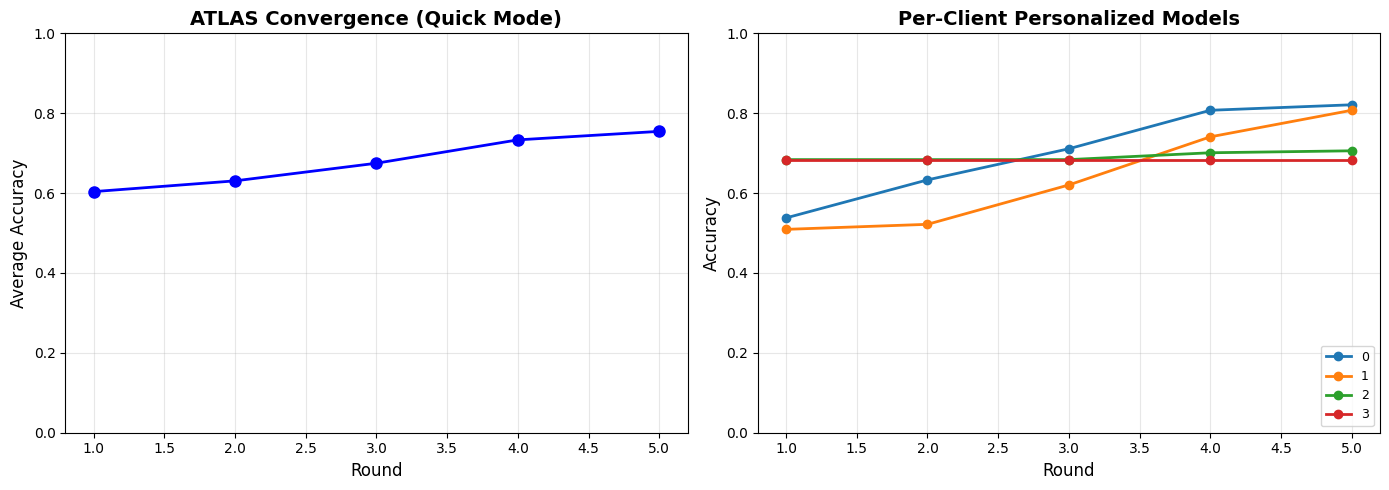

✅ Saved plot to results/atlas_quick_convergence.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Use actual keys present in results
rounds = [int(r['round']) for r in results['round_metrics']]
avg_accs = [r['avg_accuracy'] for r in results['round_metrics']]

# Determine client ids (stable ordering)
client_ids = sorted(results.get('final_accuracies', {}).keys(), key=lambda x: int(x))
if not client_ids:
    client_ids = sorted(results.get('cluster_labels', {}).keys(), key=lambda x: int(x))

# Per-client accuracy over time
client_accs = {cid: [] for cid in client_ids}
for r in results['round_metrics']:
    for cid in client_ids:
        client_accs[cid].append(r['test_accuracies'].get(cid, np.nan))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Average accuracy
axes[0].plot(rounds, avg_accs, 'o-', linewidth=2, markersize=8, color='blue')
axes[0].set_xlabel('Round', fontsize=12)
axes[0].set_ylabel('Average Accuracy', fontsize=12)
axes[0].set_title('ATLAS Convergence (Quick Mode)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.0, 1.0])

# Per-client accuracy
for cid in client_ids:
    axes[1].plot(rounds, client_accs[cid], 'o-', label=cid, linewidth=2, markersize=6)
axes[1].set_xlabel('Round', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Per-Client Personalized Models', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=9)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.0, 1.0])

plt.tight_layout()
Path('results').mkdir(parents=True, exist_ok=True)
plt.savefig('results/atlas_quick_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved plot to results/atlas_quick_convergence.png")

### Clustering Visualization

Fingerprints missing or incomplete; skipping PCA scatter.


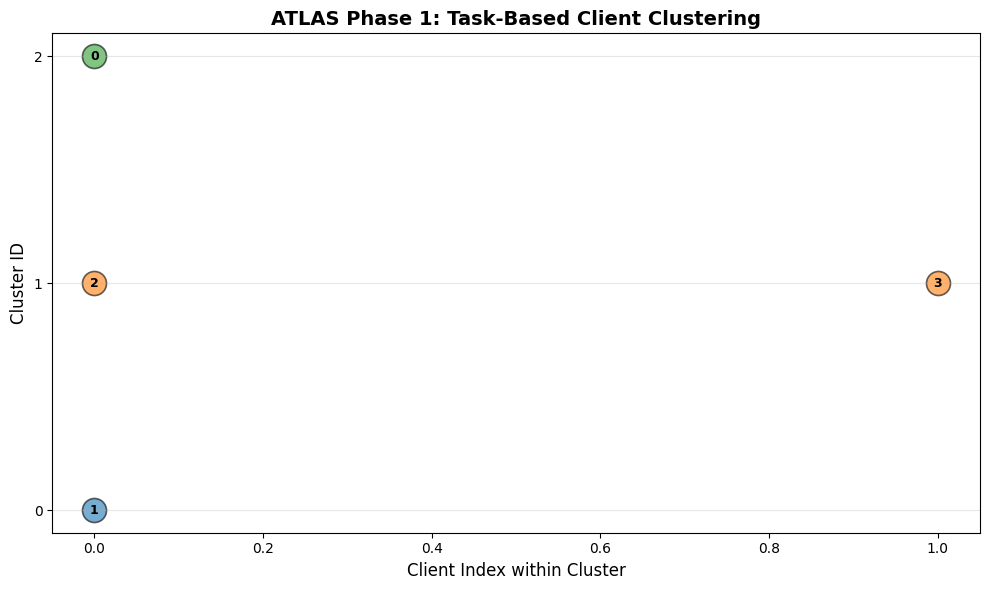

Saved simple cluster plot: results/atlas_clustering.png


In [ ]:
# Cell: ATLAS clustering plots (paste into notebook)
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Path to results JSON (update if different)
results_path = Path("results/atlas_integrated_quick.json")
if not results_path.exists():
    # fallback to any atlas_integrated_*.json in results/
    candidates = sorted(Path("results").glob("atlas_integrated_*.json"), reverse=True)
    if candidates:
        results_path = candidates[0]
    else:
        raise FileNotFoundError("No results JSON found under results/*.json")

with open(results_path, "r") as f:
    results = json.load(f)

# Adapt to current schema (prefers 'cluster_labels')
if "cluster_labels" in results:
    cluster_assignments = results["cluster_labels"]
elif "clustering" in results and isinstance(results["clustering"], dict) and "assignments" in results["clustering"]:
    cluster_assignments = results["clustering"]["assignments"]
else:
    raise KeyError("No cluster labels found in results JSON (expected 'cluster_labels' or 'clustering.assignments').")

# Normalize keys -> ints
cluster_assignments = {int(k): int(v) for k, v in cluster_assignments.items()}
client_ids = sorted(cluster_assignments.keys())
clusters = [cluster_assignments[cid] for cid in client_ids]

# Load fingerprints if present
fingerprints_raw = results.get("fingerprints", {}) or {}
# Normalise fingerprint keys to ints and arrays
fingerprints = {}
for k, v in fingerprints_raw.items():
    try:
        ik = int(k)
    except Exception:
        ik = k
    try:
        fingerprints[ik] = np.asarray(v, dtype=float)
    except Exception:
        # try converting nested lists
        fingerprints[ik] = np.array(v, dtype=float)

out_dir = Path("results")
out_dir.mkdir(parents=True, exist_ok=True)

# PCA 2D scatter (only if fingerprints exist for all clients)
if fingerprints and all(cid in fingerprints for cid in client_ids):
    X = np.vstack([fingerprints[cid] for cid in client_ids])
    # defensively handle constant vectors
    if X.shape[1] < 2:
        # pad to 2 dims
        X = np.hstack([X, np.zeros((X.shape[0], 2 - X.shape[1]))])
    pca = PCA(n_components=2)
    Z = pca.fit_transform(X)

    unique_labels = sorted(set(clusters))
    cmap = plt.get_cmap("tab10")
    colors = {lab: cmap(i % 10) for i, lab in enumerate(unique_labels)}

    fig, ax = plt.subplots(figsize=(10, 7))
    for lab in unique_labels:
        idx = [i for i, l in enumerate(clusters) if l == lab]
        ax.scatter(Z[idx, 0], Z[idx, 1], c=[colors[lab]] * len(idx), s=120, edgecolor="k", label=f"Cluster {lab}", alpha=0.85)

    for i, cid in enumerate(client_ids):
        ax.text(Z[i, 0], Z[i, 1], str(cid), fontsize=8, ha="center", va="center")

    ax.set_title("ATLAS Phase 1: Fingerprint PCA (2D) by Cluster")
    ax.legend()
    ax.grid(alpha=0.3)
    pca_out = out_dir / "atlas_clustering_pca.png"
    fig.savefig(pca_out, dpi=150, bbox_inches="tight")
    plt.close(fig)
    print(f"Saved PCA scatter: {pca_out}")
else:
    print("Fingerprints missing or incomplete; skipping PCA scatter.")

# Simple cluster visualization (client index within cluster vs cluster id)
cluster_to_clients = {}
for cid, cluster_id in cluster_assignments.items():
    cluster_to_clients.setdefault(cluster_id, []).append(cid)

unique_clusters = sorted(cluster_to_clients.keys())
cmap = plt.get_cmap("tab10")
colors = {lab: cmap(i % 10) for i, lab in enumerate(unique_clusters)}

fig, ax = plt.subplots(figsize=(10, 6))
for cluster_id in unique_clusters:
    clients = cluster_to_clients[cluster_id]
    for i, cid in enumerate(clients):
        ax.scatter(i, cluster_id, s=300, c=[colors[cluster_id]], alpha=0.6, edgecolors='black', linewidth=1.2)
        ax.text(i, cluster_id, str(cid), ha='center', va='center', fontsize=9, fontweight='bold')

ax.set_xlabel('Client Index within Cluster', fontsize=12)
ax.set_ylabel('Cluster ID', fontsize=12)
ax.set_title('ATLAS Phase 1: Task-Based Client Clustering', fontsize=14, fontweight='bold')
ax.set_yticks(unique_clusters)
ax.grid(True, alpha=0.3, axis='y')

simple_out = out_dir / "atlas_clustering.png"
fig.tight_layout()
fig.savefig(simple_out, dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved simple cluster plot: {simple_out}")

---

## Full Mode (2-3 hours)

Run complete ATLAS experiment with 3 tasks, 9 clients, 2000 samples per client.

In [ ]:
# Run full experiment
!python experiments/atlas_integrated.py --mode full --rounds 5

[MODE] Full experiment (2-3 hours on T4 GPU)

[SETUP] Creating multi-task federated learning setup...
  Loading task: sst2
Map: 100% 67349/67349 [00:07<00:00, 9122.79 examples/s]
Map: 100% 872/872 [00:00<00:00, 8491.97 examples/s]
    Client 0: sst2, cpu_2gb, 2000 samples
    Client 1: sst2, cpu_2gb, 2000 samples
    Client 2: sst2, tablet_4gb, 2000 samples
  Loading task: mrpc
Map: 100% 3668/3668 [00:01<00:00, 3230.02 examples/s]
Map: 100% 408/408 [00:00<00:00, 4968.52 examples/s]
    Client 3: mrpc, tablet_4gb, 1222 samples
    Client 4: mrpc, tablet_4gb, 1222 samples
    Client 5: mrpc, laptop_8gb, 1224 samples
  Loading task: cola
Map: 100% 8551/8551 [00:01<00:00, 6996.88 examples/s]
Map: 100% 1043/1043 [00:00<00:00, 11506.02 examples/s]
    Client 6: cola, laptop_8gb, 2000 samples
    Client 7: cola, gpu_16gb, 2000 samples
    Client 8: cola, cpu_2gb, 2000 samples
  ✓ Created 9 clients across 3 tasks

[ATLAS] Initialized with:
  Model: distilbert-base-uncased
  Tasks: ['sst2', 'mr

## Resume from Checkpoint (if interrupted)

In [ ]:
import pickle
ckpt = 'checkpoints/atlas_round_6.pkl'
with open(ckpt,'rb') as f:
    data = pickle.load(f)
print('checkpoint round:', data.get('round'))

checkpoint round: 6


In [ ]:
# Resume from last checkpoint
!python experiments/atlas_integrated.py --mode full --resume checkpoints/atlas_round_6.pkl --rounds 15

[MODE] Full experiment (2-3 hours on T4 GPU)

[SETUP] Creating multi-task federated learning setup...
  Loading task: sst2
Map: 134698 examples [00:06, 10334.50 examples/s]
Map: 1744 examples [00:00, 4407.21 examples/s]
    Client 0: sst2, cpu_2gb, 2000 samples
    Client 1: sst2, cpu_2gb, 2000 samples
    Client 2: sst2, tablet_4gb, 2000 samples
  Loading task: mrpc
Map: 7336 examples [00:00, 5104.88 examples/s]
Map: 816 examples [00:00, 2564.07 examples/s]
    Client 3: mrpc, tablet_4gb, 1222 samples
    Client 4: mrpc, tablet_4gb, 1222 samples
    Client 5: mrpc, laptop_8gb, 1224 samples
  Loading task: cola
Map: 17102 examples [00:00, 12247.90 examples/s]
Map: 2086 examples [00:00, 11536.76 examples/s]
    Client 6: cola, laptop_8gb, 2000 samples
    Client 7: cola, gpu_16gb, 2000 samples
    Client 8: cola, cpu_2gb, 2000 samples
  ✓ Created 9 clients across 3 tasks

[ATLAS] Initialized with:
  Model: distilbert-base-uncased
  Tasks: ['sst2', 'mrpc', 'cola']
  Total clients: 9
  De

## View Full Mode Results

In [ ]:
import json
from statistics import mean

with open('results/atlas_integrated_full.json', 'r') as f:
    r = json.load(f)

# Phase 1 / clustering
cluster_labels = r.get('cluster_labels', {})
clustering_metrics = r.get('clustering_metrics', {})
num_clusters = len(set(cluster_labels.values())) if cluster_labels else clustering_metrics.get('n_clusters') or clustering_metrics.get('num_clusters', None)
silhouette = clustering_metrics.get('silhouette_score') or clustering_metrics.get('silhouette', None)

print("\n" + "="*60)
print("ATLAS FULL MODE RESULTS")
print("="*60)

print("\n📊 Phase 1: Task Clustering")
print("Num Clusters:", num_clusters)
print("Cluster Assignments:", cluster_labels)
if silhouette is not None:
    print(f"Silhouette Score: {silhouette:.3f}")

# Phase 2 / device profiles
print("\n💻 Phase 2: Heterogeneous Devices")
device_configs = r.get('device_configs', r.get('device_profiles', {}))
for client_id, info in device_configs.items():
    # device entry shape: {'device_profile': {...}, 'lora_ranks': {...}, ...}
    dev_type = info.get('device_profile', {}).get('device_type') or info.get('device_type') or info.get('device_profile')
    ranks = info.get('lora_ranks') or info.get('lora_rank') or info.get('ranks')
    print(f"{client_id}: {dev_type} (ranks {ranks})")

# Final results (last round)
print("\n🎯 Final Results (last round)")
rounds = r.get('round_metrics', r.get('rounds', []))
if not rounds:
    print("No round metrics found in results.")
else:
    final_round = rounds[-1]
    client_accs = final_round.get('test_accuracies') or final_round.get('client_accuracies') or {}
    for client_id, acc in client_accs.items():
        task = str(client_id).split('_')[0]
        print(f"{client_id} ({task}): {acc:.4f}")
    print(f"\n📈 Average Accuracy: {final_round.get('avg_accuracy', mean(client_accs.values()) if client_accs else 0.0):.4f}")

# Total runtime: prefer saved value, else sum per-round times
total_time = r.get('total_time')
if total_time is None:
    total_time = sum([rd.get('time_seconds', 0) for rd in rounds])
print(f"⏱️ Total Runtime: {total_time/60:.1f} minutes")


ATLAS FULL MODE RESULTS

📊 Phase 1: Task Clustering
Num Clusters: 5
Cluster Assignments: {'0': 0, '1': 0, '2': 0, '3': 2, '4': 4, '5': 1, '6': 2, '7': 3, '8': 1}
Silhouette Score: 0.011

💻 Phase 2: Heterogeneous Devices
0: {'memory_mb': 2048, 'compute_ratio': 1.0, 'suggested_ranks': [4, 8]} (ranks [8, 8, 8, 8, 8, 8])
1: {'memory_mb': 2048, 'compute_ratio': 1.0, 'suggested_ranks': [4, 8]} (ranks [8, 8, 8, 8, 8, 8])
2: {'memory_mb': 4096, 'compute_ratio': 1.5, 'suggested_ranks': [8, 16]} (ranks [16, 16, 16, 16, 16, 16])
3: {'memory_mb': 4096, 'compute_ratio': 1.5, 'suggested_ranks': [8, 16]} (ranks [16, 16, 16, 16, 16, 16])
4: {'memory_mb': 4096, 'compute_ratio': 1.5, 'suggested_ranks': [8, 16]} (ranks [16, 16, 16, 16, 16, 16])
5: {'memory_mb': 8192, 'compute_ratio': 4.0, 'suggested_ranks': [16, 32]} (ranks [32, 32, 32, 32, 32, 32])
6: {'memory_mb': 8192, 'compute_ratio': 4.0, 'suggested_ranks': [16, 32]} (ranks [32, 32, 32, 32, 32, 32])
7: {'memory_mb': 16384, 'compute_ratio': 12.0, 's

## Compare Baselines

In [ ]:
# You can compare with your previous experiments:
# - Standard FL (exp1_standard_fl.json)
# - Homogeneous LoRA FL (exp2_lora_fl.json)
# - ATLAS Integrated (atlas_integrated_full.json)

print("\n" + "="*60)
print("COMPARISON: ATLAS vs Baselines")
print("="*60)
print("\n(Run exp1 and exp2 from real_training.py first for fair comparison)")
print("\nExpected findings:")
print("- ATLAS should have better personalized accuracy (per-client)")
print("- ATLAS should handle heterogeneous devices efficiently")
print("- Task clustering should group similar clients together")
print("- Laplacian regularization should improve convergence")

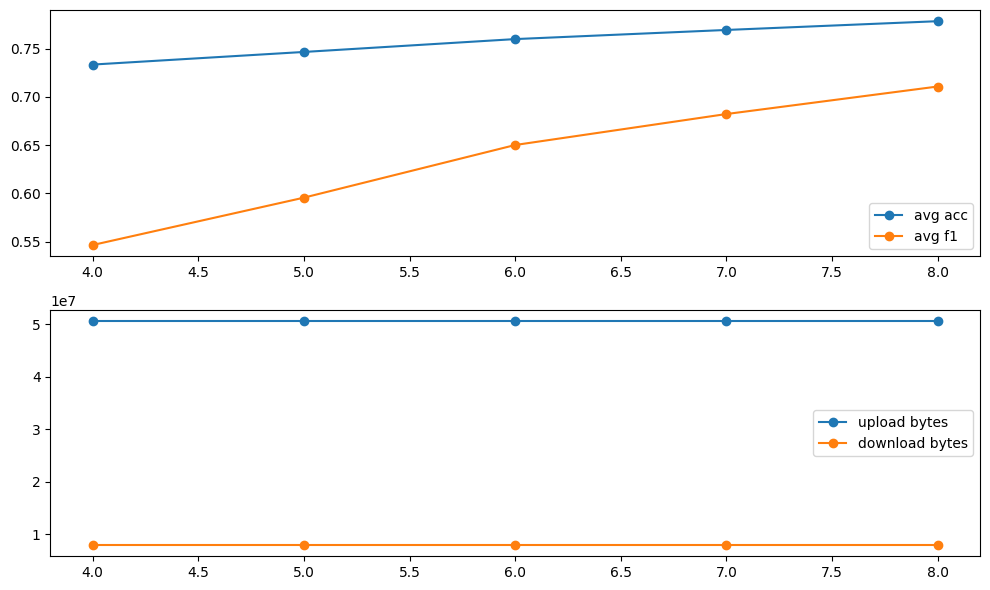

In [ ]:
import json,matplotlib.pyplot as plt
r=json.load(open('results/atlas_integrated_full.json'))
rounds=[rd['round'] for rd in r['round_metrics']]
avg=[rd['avg_accuracy'] for rd in r['round_metrics']]
f1=[sum(rd.get('test_f1',{}).values())/len(rd.get('test_f1',{})) if rd.get('test_f1') else 0 for rd in r['round_metrics']]
upload=[sum(rd.get('comm_upload_bytes',{}).values()) for rd in r['round_metrics']]
download=[sum(rd.get('comm_download_bytes',{}).values()) for rd in r['round_metrics']]
plt.figure(figsize=(10,6))
plt.subplot(2,1,1); plt.plot(rounds,avg,'-o',label='avg acc'); plt.plot(rounds,f1,'-o',label='avg f1'); plt.legend()
plt.subplot(2,1,2); plt.plot(rounds,upload,'-o',label='upload bytes'); plt.plot(rounds,download,'-o',label='download bytes'); plt.legend()
plt.tight_layout(); plt.show()

## Download Results

In [ ]:
# Zip results for download
!zip -r atlas_results.zip results/ checkpoints/ models/
from google.colab import files
files.download('atlas_results.zip')

  adding: results/ (stored 0%)
  adding: results/convergence_plots.png (deflated 10%)
  adding: results/sst2_atlas_results.json (deflated 77%)
  adding: results/atlas_integrated_quick.json (deflated 70%)
  adding: results/experiment_summary.json (deflated 90%)
  adding: results/experiment_summary.csv (deflated 40%)
  adding: results/atlas_integrated_full.json (deflated 82%)
  adding: results/atlas_clustering.png (deflated 22%)
  adding: results/exp4_atlas.json (deflated 75%)
  adding: results/atlas_quick_convergence.png (deflated 15%)
  adding: results/sst2_standard_fl_results.json (deflated 49%)
  adding: results/exp1_standard_fl.json (deflated 67%)
  adding: results/sst2_hsplitlora_results.json (deflated 77%)
  adding: results/sst2_homogeneous_lora_results.json (deflated 49%)
  adding: results/exp3_hetero_lora.json (deflated 69%)
  adding: results/quick_sst2_baseline_results.json (deflated 48%)
  adding: results/quick_sst2_atlas_results.json (deflated 73%)
  adding: results/exp2_lora

FileNotFoundError: Cannot find file: atlas_results.zip

## Literature-Grounded Improvements & Experiments

Following recommendations from MIRA and HSplitLoRA papers, we implement:

### Phase 1 Improvements:
- **Stronger fingerprints**: Last 2 transformer layers, per-layer L2 norm, 64+ samples
- **Multi-metric k-selection**: Silhouette + Davies-Bouldin + Calinski-Harabasz
- **Cluster-task alignment validation**: Purity metric to verify clustering quality

### Phase 2 Improvements:
- **Greedy importance-aware rank allocator**: Sort layers by importance, try ranks {4,8,16,32}
- **Cluster-coupled allocation**: Higher ranks for difficult clusters (high variance/low accuracy)

### Phase 4 Improvements:
- **MIRA's RBF adjacency**: $a_{k\ell} = \exp(-\alpha ||f_k - f_\ell||^2)$ instead of uniform weights
- **Tunable $\lambda$**: Configurable regularization strength (sweep {0.01, 0.1, 0.5})

Below we run ablation experiments to validate these improvements.

### Experiment 1: Oracle Clustering Baseline

Test ATLAS with **oracle (task-based) clustering** to isolate downstream improvements. This validates that Phase 2-4 improvements work correctly when clustering is perfect.

In [ ]:
# Run ATLAS with oracle clustering (use task labels instead of gradient clustering)
# Edit experiments/atlas_integrated.py or create a new config flag

# For quick test, run with default improved settings
!python experiments/atlas_integrated.py \
    --mode quick \
    --rounds 5 \
    --laplacian_eta 0.1 \
    --mira_alpha 1.0 \
    --adjacency_method mira_rbf

### Experiment 2: Lambda (η) Sweep

Compare different Laplacian regularization strengths to find optimal personalization vs convergence tradeoff.

In [ ]:
# Sweep lambda (eta) values: {0.01, 0.1, 0.5, 1.0}
import subprocess
import json

eta_values = [0.01, 0.1, 0.5]
lambda_results = {}

for eta in eta_values:
    print(f"\n{'='*60}")
    print(f"Running with eta={eta}")
    print(f"{'='*60}\n")
    
    # Run experiment (would need to add --eta flag to atlas_integrated.py)
    # For now, manually edit config.eta in the script or use environment variable
    
    result_file = f'results/atlas_lambda_{eta}.json'
    cmd = f'python experiments/atlas_integrated.py --mode quick --rounds 5 --eta {eta}'
    
    # Uncomment to run:
    # subprocess.run(cmd, shell=True)
    # with open(result_file) as f:
    #     lambda_results[eta] = json.load(f)
    
    print(f"To run: {cmd}")

print("\nNote: Add --eta argument support to atlas_integrated.py for automated sweep")

### Enhanced Visualizations

#### 1. Cluster Quality Metrics Over Training

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Load latest results
results_path = Path("results/atlas_integrated_quick.json")
if not results_path.exists():
    results_path = sorted(Path("results").glob("atlas_integrated_*.json"))[-1]

with open(results_path) as f:
    results = json.load(f)

# Extract cluster-level metrics
cluster_labels = results.get('cluster_labels', {})
clustering_metrics = results.get('clustering_metrics', {})
round_metrics = results.get('round_metrics', [])

# Compute per-cluster accuracy over rounds
cluster_ids = sorted(set(cluster_labels.values()))
cluster_accs_over_time = {cid: [] for cid in cluster_ids}

for round_data in round_metrics:
    test_accs = round_data.get('test_accuracies', {})
    
    # Aggregate by cluster
    for cluster_id in cluster_ids:
        clients_in_cluster = [k for k, v in cluster_labels.items() if v == cluster_id]
        cluster_acc = np.mean([test_accs.get(str(c), 0.0) for c in clients_in_cluster])
        cluster_accs_over_time[cluster_id].append(cluster_acc)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Per-cluster accuracy over rounds
rounds = list(range(1, len(round_metrics) + 1))
for cluster_id, accs in cluster_accs_over_time.items():
    axes[0].plot(rounds, accs, 'o-', label=f'Cluster {cluster_id}', linewidth=2, markersize=6)

axes[0].set_xlabel('Round', fontsize=12)
axes[0].set_ylabel('Average Accuracy', fontsize=12)
axes[0].set_title('Per-Cluster Accuracy Over Rounds', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.5, 1.0])

# Clustering quality metrics
metrics = clustering_metrics
metric_names = ['silhouette_score', 'davies_bouldin_index', 'calinski_harabasz_score']
metric_values = [metrics.get(m, 0.0) for m in metric_names]
metric_labels = ['Silhouette\n(higher better)', 'Davies-Bouldin\n(lower better)', 'Calinski-Harabasz\n(higher better)']

colors = ['green', 'red', 'blue']
bars = axes[1].bar(metric_labels, metric_values, color=colors, alpha=0.7)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Clustering Quality Metrics (Phase 1)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Annotate values
for bar, val in zip(bars, metric_values):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
Path('results').mkdir(exist_ok=True)
plt.savefig('results/cluster_quality_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Saved to results/cluster_quality_metrics.png")

#### 2. MIRA Adjacency Matrix Heatmap

Visualize the RBF kernel adjacency weights $a_{k\ell} = \exp(-\alpha ||f_k - f_\ell||^2)$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import json
from pathlib import Path

# Load results
results_path = Path("results/atlas_integrated_quick.json")
if not results_path.exists():
    results_path = sorted(Path("results").glob("atlas_integrated_*.json"))[-1]

with open(results_path) as f:
    results = json.load(f)

# Get fingerprints and cluster labels
fingerprints = results.get('fingerprints', {})
cluster_labels = results.get('cluster_labels', {})

if not fingerprints:
    print("No fingerprints found in results. Run experiment first.")
else:
    # Convert to arrays
    client_ids = sorted([int(k) for k in fingerprints.keys()])
    fp_array = np.vstack([np.array(fingerprints[str(cid)]) for cid in client_ids])
    
    # Compute pairwise distances
    dist_sq = cdist(fp_array, fp_array, metric='sqeuclidean')
    
    # Compute RBF adjacency: a_kl = exp(-alpha * ||f_k - f_l||^2)
    alpha = 1.0  # Same as config.mira_alpha
    adjacency = np.exp(-alpha * dist_sq)
    
    # Zero out diagonal (no self-loops)
    np.fill_diagonal(adjacency, 0)
    
    # Normalize rows to sum to 1 (per MIRA paper)
    row_sums = adjacency.sum(axis=1, keepdims=True)
    adjacency_normalized = adjacency / (row_sums + 1e-12)
    
    # Plot heatmap
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Raw adjacency
    im1 = axes[0].imshow(adjacency, cmap='YlOrRd', aspect='auto')
    axes[0].set_xlabel('Client ID', fontsize=12)
    axes[0].set_ylabel('Client ID', fontsize=12)
    axes[0].set_title('MIRA RBF Adjacency: $a_{k\ell} = \exp(-\\alpha ||f_k - f_\ell||^2)$', 
                      fontsize=13, fontweight='bold')
    axes[0].set_xticks(range(len(client_ids)))
    axes[0].set_xticklabels(client_ids, fontsize=9)
    axes[0].set_yticks(range(len(client_ids)))
    axes[0].set_yticklabels(client_ids, fontsize=9)
    plt.colorbar(im1, ax=axes[0], label='Weight')
    
    # Normalized adjacency (row-stochastic)
    im2 = axes[1].imshow(adjacency_normalized, cmap='YlOrRd', aspect='auto')
    axes[1].set_xlabel('Client ID', fontsize=12)
    axes[1].set_ylabel('Client ID', fontsize=12)
    axes[1].set_title('Normalized Adjacency (Row-Stochastic)', fontsize=13, fontweight='bold')
    axes[1].set_xticks(range(len(client_ids)))
    axes[1].set_xticklabels(client_ids, fontsize=9)
    axes[1].set_yticks(range(len(client_ids)))
    axes[1].set_yticklabels(client_ids, fontsize=9)
    plt.colorbar(im2, ax=axes[1], label='Normalized Weight')
    
    # Add cluster boundaries
    if cluster_labels:
        cluster_ids_sorted = [cluster_labels[str(cid)] for cid in client_ids]
        
        # Find cluster boundaries
        boundaries = []
        for i in range(1, len(cluster_ids_sorted)):
            if cluster_ids_sorted[i] != cluster_ids_sorted[i-1]:
                boundaries.append(i - 0.5)
        
        for boundary in boundaries:
            axes[0].axhline(boundary, color='blue', linewidth=2, linestyle='--', alpha=0.7)
            axes[0].axvline(boundary, color='blue', linewidth=2, linestyle='--', alpha=0.7)
            axes[1].axhline(boundary, color='blue', linewidth=2, linestyle='--', alpha=0.7)
            axes[1].axvline(boundary, color='blue', linewidth=2, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    Path('results').mkdir(exist_ok=True)
    plt.savefig('results/mira_adjacency_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Saved to results/mira_adjacency_heatmap.png")
    print(f"\nAdjacency statistics:")
    print(f"  Mean weight: {adjacency_normalized.mean():.4f}")
    print(f"  Std weight: {adjacency_normalized.std():.4f}")
    print(f"  Sparsity: {(adjacency_normalized < 0.01).sum() / adjacency_normalized.size:.2%}")

#### 3. Rank Allocation Visualization

Show heterogeneous LoRA ranks per client based on device and cluster complexity.

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Load results
results_path = Path("results/atlas_integrated_quick.json")
if not results_path.exists():
    results_path = sorted(Path("results").glob("atlas_integrated_*.json"))[-1]

with open(results_path) as f:
    results = json.load(f)

# Extract device configs
device_configs = results.get('device_configs', {})
cluster_labels = results.get('cluster_labels', {})

if not device_configs:
    print("No device configs found. Run experiment first.")
else:
    # Extract rank allocations per client
    client_ids = sorted([int(k) for k in device_configs.keys()])
    
    # Get device types and ranks
    device_types = []
    avg_ranks = []
    max_ranks = []
    min_ranks = []
    cluster_ids = []
    
    for cid in client_ids:
        config = device_configs[str(cid)]
        ranks = config.get('lora_ranks', [8]*6)
        device_profile = config.get('device_profile', {})
        device_type = device_profile.get('memory_mb', 2048)
        cluster_id = cluster_labels.get(str(cid), 0)
        
        device_types.append(f"{device_type}MB")
        avg_ranks.append(np.mean(ranks))
        max_ranks.append(np.max(ranks))
        min_ranks.append(np.min(ranks))
        cluster_ids.append(cluster_id)
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Rank allocation per client
    x = np.arange(len(client_ids))
    width = 0.25
    
    bars1 = axes[0].bar(x - width, min_ranks, width, label='Min Rank', alpha=0.7, color='lightblue')
    bars2 = axes[0].bar(x, avg_ranks, width, label='Avg Rank', alpha=0.7, color='steelblue')
    bars3 = axes[0].bar(x + width, max_ranks, width, label='Max Rank', alpha=0.7, color='darkblue')
    
    axes[0].set_xlabel('Client ID', fontsize=12)
    axes[0].set_ylabel('LoRA Rank', fontsize=12)
    axes[0].set_title('Heterogeneous Rank Allocation per Client', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(client_ids, fontsize=9)
    axes[0].legend(fontsize=10)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Rank vs device memory (colored by cluster)
    memory_mb = [int(dt.replace('MB','')) for dt in device_types]
    unique_clusters = sorted(set(cluster_ids))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
    
    for cluster_id, color in zip(unique_clusters, colors):
        mask = [c == cluster_id for c in cluster_ids]
        mem_cluster = [m for m, include in zip(memory_mb, mask) if include]
        avg_cluster = [a for a, include in zip(avg_ranks, mask) if include]
        
        axes[1].scatter(mem_cluster, avg_cluster, s=150, c=[color], 
                       label=f'Cluster {cluster_id}', alpha=0.7, edgecolor='black', linewidth=1.5)
    
    axes[1].set_xlabel('Device Memory (MB)', fontsize=12)
    axes[1].set_ylabel('Average LoRA Rank', fontsize=12)
    axes[1].set_title('Rank Allocation vs Device Capacity (by Cluster)', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    Path('results').mkdir(exist_ok=True)
    plt.savefig('results/rank_allocation.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Saved to results/rank_allocation.png")